# draft 20220206

To avoid git conflict with others modification, I create a new notebook with most code copied from the previous one `load_data.ipynb`

TLDR

1. code below takes less than 5 minutes to finish.
2. `anti_alising=True` improve score greatly for both QSVM and QNN
3. different `resize_image_size` (equivalently number of qubits) helps a little bit, but not remarkable. 
4. no large difference between `QSVM` and `QNN` results
5. results with different parameter need only one line of code (see `QSVM/QNN all in one` section), please try it

**reminder** to run the code quickly, remember to set `class_size=24` in `load_data` section. `class_size=240` might spend several hours.

TODO (but time maybe not enough)

1. real quantum computer device?
2. `class_size=240`
3. other labels: `alpha`, `beta`, etc.

Table of Content

1. how `skimage.transform.resize` works
   * `skimage.transform.resize` on 1-d image
   * `skimage.transform.resize` on 2-d image
2. load data
   * plot part of images and resized images
   * select training set and test set
3. quantum SVM (QSVM) model
4. QSVM all in one
   * compare `anti_alising=True` and `anti_alising=False`
   * compare `resize_image_size`
5. quantum Neural Network (QNN) model
6. QNN all in one
   * compare `anti_alising=True` and `anti_alising=False`
   * compare `resize_image_size`

In [2]:
import os
import glob
import json
import hashlib
import PIL.Image
import numpy as np
import matplotlib
import matplotlib.patches
import matplotlib.pyplot as plt

import skimage
import sklearn.model_selection
import sklearn.svm

import concurrent.futures
import qiskit
import qiskit.providers.aer
from qiskit.circuit.library import ZFeatureMap, ZZFeatureMap, PauliFeatureMap, TwoLocal
from qiskit.algorithms.optimizers import SPSA, COBYLA, GradientDescent
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit_machine_learning.neural_networks import CircuitQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.utils.loss_functions import L2Loss, CrossEntropyLoss

## how `skimage.transform.resize` works

TLDR

1. `skimage.transform.resize()` is the bilinear interpolation scheme [wiki](https://en.wikipedia.org/wiki/Bilinear_interpolation)
2. `skimage.transform.resize(anti_aliasing=False)` might be not good as `skimage.transform.resize(anti_aliasing=True)` with a suitable `anti_aliasing_sigma` value, since the former only use **part of** pixels (roughly 4 pixels) of the whole image
3. when `skimage.transform.resize(anti_aliasing=True, anti_aliasing_sigma=xxx)`, default value for `anti_aliasing_sigma` is `(s-1)/2` where `s` is the downsampling factor, see [skimage-doc](https://scikit-image.org/docs/dev/api/skimage.transform.html#resize). `anti_aliasing_sigma` controls the Gaussian filter

### `skimage.transform.resize` on 1-d image

resize `(height=1,width=8)` image to `(height=1,width=2)`. In the figure below, 8 blue points represents a `(height=1,width=8)` image (the pixel position), 2 orange points represents a `(height=1,width=2)` image that downsampling from `(height=1,width=8)` image.

when `anti_aliasing=False`, only the 4 points in red boxes make contribution to the downsampled image, points in the left (right) box contribute to the left (right) pixel by some linear combinations.

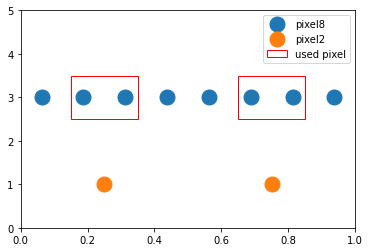

In [3]:
# downsample (height=1,width=8) image to (height=1,width=2) image
hf0 = lambda x: np.arange(1, 2*x, 2)/(2*x)
pixel8 = hf0(8)
pixel2 = hf0(2)

fig,ax = plt.subplots()
ax.plot(pixel8, np.ones_like(pixel8)*3, '.', markersize=30, label='pixel8')
ax.plot(pixel2, np.ones_like(pixel2)*1, '.', markersize=30, label='pixel2')
ax.add_patch(matplotlib.patches.Rectangle((0.15,2.5),height=1,width=0.2,fill=False,color='r',label='used pixel'))
ax.add_patch(matplotlib.patches.Rectangle((0.65,2.5),height=1,width=0.2,fill=False,color='r'))
ax.legend()
ax.set_xlim(0,1)
_ = ax.set_ylim(0, 5)

In [4]:
# randomly generate a (height=1,width=8) image (image_pixel8), and modified one unused pixel (image_pixel8_modified)
# downsampling two images above with anti_aliasing=False will get exactly the same results, image_pixel2 and image_pixel2_modified,
# which means that pixel has no contribution.
# you can also try anti_aliasing=True, then almost all pixels should have contribution
anti_aliasing = False

image_pixel8 = np.random.rand(1, 8)
image_pixel2 = skimage.transform.resize(image_pixel8, (1, 2), order=1, anti_aliasing=anti_aliasing)

image_pixel8_modified = image_pixel8.copy()
image_pixel8_modified[0,0] = np.random.rand() #replace one unused pixel (pixel-0) to a random value
image_pixel2_modified = skimage.transform.resize(image_pixel8_modified, (1, 2), order=1, anti_aliasing=anti_aliasing)

np.set_printoptions(precision=4, linewidth=220)
print('image_pixel8:', image_pixel8)
print('image_pixel2:', image_pixel2)
print('image_pixel8_modified:', image_pixel8_modified)
print('image_pixel2_modified:', image_pixel2_modified) #should be the same as image_pixel2 when anti_aliasing=False

image_pixel8: [[0.2961 0.8055 0.4287 0.9895 0.134  0.7221 0.097  0.1473]]
image_pixel2: [[0.6171 0.4095]]
image_pixel8_modified: [[0.8974 0.8055 0.4287 0.9895 0.134  0.7221 0.097  0.1473]]
image_pixel2_modified: [[0.6171 0.4095]]


### `skimage.transform.resize` on 2-d image

resize `(height=8,width=8)` image to `(height=2,width=2)`

In [5]:
anti_aliasing = False

image_pixel8 = np.random.rand(8, 8)
image_pixel2 = skimage.transform.resize(image_pixel8, (2, 2), order=1, anti_aliasing=anti_aliasing)

image_pixel8_modified = image_pixel8.copy()
image_pixel8_modified[0,0] = np.random.rand() #replace one unused pixel (pixel-0) to a random value
image_pixel2_modified = skimage.transform.resize(image_pixel8_modified, (2, 2), order=1, anti_aliasing=anti_aliasing)

np.set_printoptions(precision=4, linewidth=220)
# print('image_pixel8:', image_pixel8)
print('image_pixel2:\n', image_pixel2)
# print('image_pixel8_modified:', image_pixel8_modified)
print('image_pixel2_modified:\n', image_pixel2_modified) #should be the same as image_pixel2 when anti_aliasing=False

image_pixel2:
 [[0.4958 0.6618]
 [0.7586 0.3793]]
image_pixel2_modified:
 [[0.4958 0.6618]
 [0.7586 0.3793]]


## load data

download dataset from kaggle [https://www.kaggle.com/xainano/handwrittenmathsymbols](https://www.kaggle.com/xainano/handwrittenmathsymbols) (a large `rar` file within `zip` file), and extract the images. The folder structure should be similar as below

```bash
Team-3-Quantum-Hackers-Project/
├── README.md
├── LICENSE
├── .gitignore
├── load_data.ipynb
└── extracted_images/
    ├── 0/
    |   ├── 0_100070.jpg
    |   ├── 0_100080.jpg
    |   ├── 0_100081.jpg
    |   └── ...
    ├── 1/
    ├── !/
    ├── (/
    ├── )/
    └── ...
```

In [6]:
# get filepath and label of all images
datadir = 'extracted_images'
all_label = os.listdir(datadir)
all_image_path = {x:[os.path.join(datadir,x,y) for y in os.listdir(os.path.join(datadir,x))] for x in all_label}
    
print('all label:', all_label)
print('some image path:')
for x in list(all_image_path.keys())[:4]:
    print(x, all_image_path[x][:2])

all label: ['beta', 'infty', 'cos', '6', '0', 'prime', '=', 'gt', 'o', 'lt', 'y', 'b', '!', 'T', 'C', 'leq', 'R', 'exists', 'p', 'N', '3', '{', 'H', 'z', 'ascii_124', 'alpha', 'sigma', '9', 'int', 'q', 'l', 'lambda', 'A', 'theta', '2', 'S', '5', 'sqrt', '7', 'sum', '4', 'v', 'e', 'M', 'forall', 'j', '-', ')', '1', 'w', '(', 'phi', 'i', ',', 'lim', 'Delta', 'G', '8', 'u', 'k', 'rightarrow', 'div', 'neq', '[', 'pi', ']', 'f', 'geq', 'pm', 'forward_slash', 'gamma', '}', 'X', '+', 'times', 'log', 'tan', 'd', 'in', 'sin', 'ldots', 'mu']
some image path:
beta ['extracted_images/beta/beta_57145.jpg', 'extracted_images/beta/exp26500.jpg']
infty ['extracted_images/infty/exp96368.jpg', 'extracted_images/infty/exp78043.jpg']
cos ['extracted_images/cos/exp48148.jpg', 'extracted_images/cos/exp91430.jpg']
6 ['extracted_images/6/exp22030.jpg', 'extracted_images/6/6_56393.jpg']


### Plot parts of images and resized images

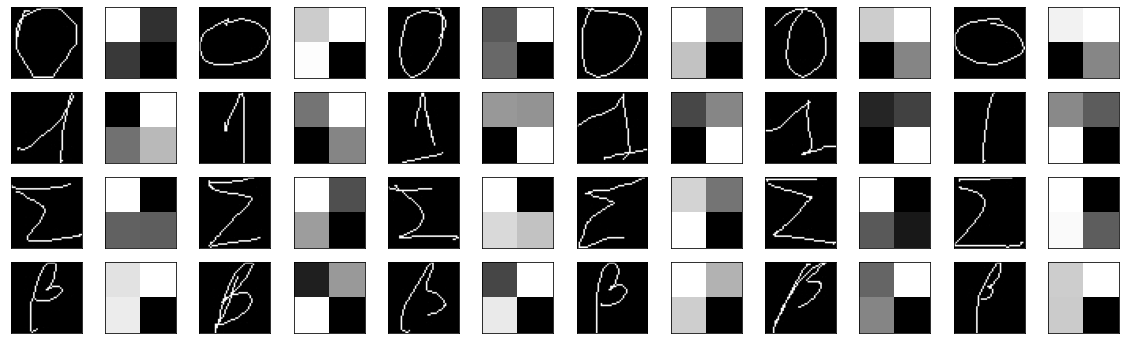

In [7]:
# hyper-parameter, modify below to see the effects
plot_label_list = ['0', '1', 'sum', 'beta']
num_column = 6
resize_image_size = 2,2
anti_aliasing = True
anti_aliasing_sigma = None #default to (s-1)/2 where s=45/2 is the downsamplign factor

# plot function
fig, ax_list = plt.subplots(nrows=len(plot_label_list), ncols=2*num_column, figsize=(20, 6))
for i in range(len(plot_label_list)):
    image_list = all_image_path[plot_label_list[i]]
    random_index = np.random.choice(np.arange(len(image_list)), size=num_column)
    for j in range(num_column):
        path = image_list[random_index[j]]
        image = np.array(PIL.Image.open(path))
        image_small = skimage.transform.resize(image, resize_image_size,
                           anti_aliasing=anti_aliasing, anti_aliasing_sigma=anti_aliasing_sigma)
        ax_list[i,2*j].imshow(image, cmap=plt.cm.gray_r)
        ax_list[i,2*j].set_xticks([])
        ax_list[i,2*j].set_yticks([])
        ax_list[i,2*j+1].imshow(image_small, cmap=plt.cm.gray_r)
        ax_list[i,2*j+1].set_xticks([])
        ax_list[i,2*j+1].set_yticks([])

### select training set and test set

1. select label
2. select part of the data, otherwise itt takes too long to train on the whole dataset
3. split train and test set

In [8]:
# hyper-parameter, you can modify it to choose different label, etc.
seed = 42 #to fix the result, change it to seed=23 or some other integer or None
labels = ['0', '1'] #binary classification
label_to_int = {labels[0]:0, labels[1]:1}
#class_size=240 will take roughly half an hour to train, class_size=24 will take roughly 1 minutes
class_size = 24

data_list = []
label_list = []
for x in labels:
    image_list = all_image_path[x]
    random_index = np.random.choice(np.arange(len(image_list)), size=class_size)
    for i in random_index:
        path = image_list[i]
        data_list.append(np.array(PIL.Image.open(image_list[i])))
        label_list.append(label_to_int[x])

# data_list = [skimage.transform.resize(x, resize_image_size, anti_aliasing=False).reshape(-1) for x in data_list]
data_list = np.stack(data_list)/255 #normalized to [0,1]
label_list = np.array(label_list)
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(
            data_list, label_list, test_size=0.2, shuffle=True, random_state=seed)
print('x_train include {} images, each of size ({},{}), range from {} to {}'.format(*x_train.shape, x_train.min(), x_train.max()))
print('x_test include {} images, each of size ({},{}), range from {} to {}'.format(*x_test.shape, x_test.min(), x_test.max()))

x_train include 38 images, each of size (45,45), range from 0.0 to 1.0
x_test include 10 images, each of size (45,45), range from 0.0 to 1.0


auxiliary function to save and load result

since training time is quite long, we can save the computed result and load it next time.

In [19]:
RESULT_DIR = 'result'

def save_result(param, **kwargs):
    param['class_size'] = class_size #number of sample per label
    if not os.path.exists(RESULT_DIR):
        os.makedirs(RESULT_DIR)
    tmp0 = json.dumps(param)
    filename = int(hashlib.sha1(tmp0.encode("utf-8")).hexdigest(), 16) % (10 ** 8) #use hash as filename
    filepath = os.path.join(RESULT_DIR, f'{filename}.json')
    for key,value in kwargs.items():
        if isinstance(value,np.ndarray):
            kwargs[key] = value.tolist()
    kwargs['param'] = param
    with open(filepath, 'w', encoding='utf-8') as fid:
        json.dump(kwargs, fid, indent=4)
    return filepath


def load_result(hashkey):
    filepath = os.path.join(RESULT_DIR, f'{hashkey}.json')
    assert os.path.exists(filepath)
    with open(filepath, 'r', encoding='utf-8') as fid:
        ret = json.load(fid)
    param = ret.pop('param')
    return param, ret

## quantum SVM model

hyper-parameter

In [10]:
feature_dim = 4
resize_image_size = 2,2
anti_aliasing = True
anti_aliasing_sigma = None #default to (s-1)/2 where s=44/2 is the downsamplign factor
# normalize the data into range [normalize_min,normalize_max]
normalize_min = 0
normalize_max = 1
feature_type = 'ZZ' #Pauli or ZZ
# TODO amplitude encoding
feature_repeat = 2 #see ZZFeatureMap argument
qasm_shots = 1024
seed = None #random seed

# feature_dim should be the same as #pixel
assert resize_image_size[0]*resize_image_size[1]==feature_dim

resize and normalize

In [11]:
# resize x_train to resize_image_size, and scale it to range [normalize_min,normalize_max]
tmp0 = np.stack([skimage.transform.resize(x, resize_image_size,
                       anti_aliasing=anti_aliasing, anti_aliasing_sigma=anti_aliasing_sigma).reshape(-1) for x in x_train])
scale_a = (normalize_max-normalize_min)/(tmp0.max()-tmp0.min())
scale_b = normalize_min - tmp0.min()*scale_a
x_train_normed = tmp0*scale_a + scale_b

# resize x_test, and apply the same scale as x_train
tmp0 = np.stack([skimage.transform.resize(x, resize_image_size,
                       anti_aliasing=anti_aliasing, anti_aliasing_sigma=anti_aliasing_sigma).reshape(-1) for x in x_test])
x_test_normed = tmp0*scale_a + scale_b

# print the shape, range information
print('x_train_normed include {} images, each of shape ({}), range from {:.3f} to {:.3f}'.format(*x_train_normed.shape, x_train_normed.min(), x_train_normed.max()))
print('x_test_normed include {} images, each of shape ({}), range from {:.3f} to {:.3f}'.format(*x_test_normed.shape, x_test_normed.min(), x_test_normed.max()))

x_train_normed include 38 images, each of shape (4), range from 0.000 to 1.000
x_test_normed include 10 images, each of shape (4), range from 0.224 to 0.962


create a new quantum simulator, or we can replace it with a real quantum computer instance in the future.

In [12]:
aer_qasm_sim = qiskit.providers.aer.QasmSimulator()
qi_aer_qasm = qiskit.utils.QuantumInstance(aer_qasm_sim, shots=qasm_shots, seed_simulator=seed)

create `feature_map`, `feature_kernel`, and draw the circuit

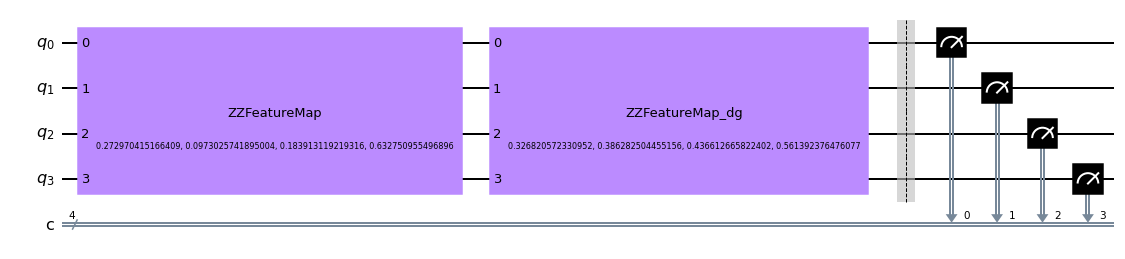

In [13]:
if feature_type=='ZZ':
    feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=feature_repeat, entanglement='linear')
else:
    feature_map = PauliFeatureMap(feature_dimension=feature_dim, reps=feature_repeat, entanglement='linear')
feature_kernel = QuantumKernel(feature_map=feature_map, quantum_instance=qi_aer_qasm)

#Constructing the inner product circuit for given datapoints and feature map
feature_circuit = feature_kernel.construct_circuit(x_train_normed[0], x_train_normed[1])
feature_circuit.decompose().draw('mpl')

train and evaluate the model

In [14]:
# train quantum SVM model with train set
model = sklearn.svm.SVC(kernel= feature_kernel.evaluate)
model.fit(x_train_normed, y_train)

# evaluate QSVM using train set
accuracy = model.score(x_train_normed, y_train)
print(f'classification accuracy on train set (size={len(y_train)}): {accuracy}')

# evaluate QSVM using set set
accuracy = model.score(x_test_normed, y_test)
print(f'classification accuracy on test set (size={len(y_test)}): {accuracy}')

classification accuracy on train set (size=38): 1.0
classification accuracy on test set (size=10): 0.9


## QSVM all in one

Bundle all above in one code block, and run it with different hyper-parameter. Please go through the section above to get the meaning of the below code.

In [15]:
def QSVM_all_in_one(param:dict):
    param = dict(param) #make a copy
    # set default value
    param.setdefault('feature_dim', 4)
    param.setdefault('resize_image_size', (2,2))
    param.setdefault('anti_aliasing', True)
    #anti_aliasing_sigma default to (s-1)/2 where s=44/2 is the downsamplign factor
    param.setdefault('anti_aliasing_sigma', None)
    # normalize the data into range [normalize_min,normalize_max]
    param.setdefault('normalize_min', 0)
    param.setdefault('normalize_max', 1)
    param.setdefault('feature_type', 'ZZ') #ZZ or Pauli
    # TODO amplitude encoding
    param.setdefault('feature_repeat', 2) #see ZZFeatureMap argument
    param.setdefault('qasm_shots', 1024)
    param.setdefault('seed', None)
    
    feature_dim = param['feature_dim']
    resize_image_size = param['resize_image_size']
    anti_aliasing = param['anti_aliasing']
    anti_aliasing_sigma = param['anti_aliasing_sigma']
    normalize_min = param['normalize_min']
    normalize_max = param['normalize_max']
    feature_type = param['feature_type']
    feature_repeat = param['feature_repeat']
    qasm_shots = param['qasm_shots']
    seed = param['seed']

    # resize x_train to resize_image_size, and scale it to range [normalize_min,normalize_max]
    tmp0 = np.stack([skimage.transform.resize(x, resize_image_size,
                           anti_aliasing=anti_aliasing, anti_aliasing_sigma=anti_aliasing_sigma).reshape(-1) for x in x_train])
    scale_a = (normalize_max-normalize_min)/(tmp0.max()-tmp0.min())
    scale_b = normalize_min - tmp0.min()*scale_a
    x_train_normed = tmp0*scale_a + scale_b

    # resize x_test, and apply the same scale as x_train
    tmp0 = np.stack([skimage.transform.resize(x, resize_image_size,
                           anti_aliasing=anti_aliasing, anti_aliasing_sigma=anti_aliasing_sigma).reshape(-1) for x in x_test])
    x_test_normed = tmp0*scale_a + scale_b

    # print the shape, range information
    print('x_train_normed include {} images, each of shape ({}), range from {:.3f} to {:.3f}'.format(*x_train_normed.shape, x_train_normed.min(), x_train_normed.max()))
    print('x_test_normed include {} images, each of shape ({}), range from {:.3f} to {:.3f}'.format(*x_test_normed.shape, x_test_normed.min(), x_test_normed.max()))

    aer_qasm_sim = qiskit.providers.aer.QasmSimulator()
    qi_aer_qasm = qiskit.utils.QuantumInstance(aer_qasm_sim, shots=qasm_shots, seed_simulator=seed)

    if feature_type=='ZZ':
        feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=feature_repeat, entanglement='linear')
    else:
        feature_map = PauliFeatureMap(feature_dimension=feature_dim, reps=feature_repeat, entanglement='linear')
    feature_kernel = QuantumKernel(feature_map=feature_map, quantum_instance=qi_aer_qasm)

    # train quantum SVM model with train set
    model = sklearn.svm.SVC(kernel= feature_kernel.evaluate)
    model.fit(x_train_normed, y_train)

    train_accuracy = model.score(x_train_normed, y_train)
    print(f'classification accuracy on train set (size={len(y_train)}): {train_accuracy}')

    test_accuracy = model.score(x_test_normed, y_test)
    print(f'classification accuracy on test set (size={len(y_test)}): {test_accuracy}')
    return param,train_accuracy,test_accuracy


### compare `anti_aliasing=True` and `anti_aliasing=False`

`class_size=24` (total `48` samples)

| `anti_aliasing` | train-accuracy | test-accuracy |
| :-: | :-: | :-: |
| `True` | `1.0` | `0.9` |
| `False` | `0.631` | `0.4` |

conclusion: `anti_aliasing=True` is much better than `anti_aliasing=False`

In [21]:
param = {'anti_aliasing':True, 'seed':None}
param,train_accuracy,test_accuracy = QSVM_all_in_one(param)
save_result(param=param, train_accuracy=train_accuracy, test_accuracy=test_accuracy)

x_train_normed include 38 images, each of shape (4), range from 0.000 to 1.000
x_test_normed include 10 images, each of shape (4), range from 0.224 to 0.962
classification accuracy on train set (size=38): 1.0
classification accuracy on test set (size=10): 0.9


'result/39645972.json'

In [22]:
param = {'anti_aliasing':False, 'seed':None}
param,train_accuracy,test_accuracy = QSVM_all_in_one(param)
save_result(param=param, train_accuracy=train_accuracy, test_accuracy=test_accuracy)

x_train_normed include 38 images, each of shape (4), range from 0.000 to 1.000
x_test_normed include 10 images, each of shape (4), range from 0.001 to 1.000
classification accuracy on train set (size=38): 0.631578947368421
classification accuracy on test set (size=10): 0.4


'result/50987404.json'

### compare `resize_image_size`

for different `resize_image_size`, we have the equal number of qubit `#qubits=height*width`

`class_size=24` (total `48` samples)

| `resize_image_size` | train-accuracy | test-accuracy |
| :-: | :-: | :-: |
| `(1,2)` | `0.921` | `0.9` |
| `(2,1)` | `0.921` | `0.9` |
| `(2,2)` | `1.0` | `0.9` |
| `(3,3)` | `1.0` | `0.9` |

conclusion: model with more qubits might be more powerful than that with less qubits

In [28]:
param = {'anti_aliasing':True, 'feature_dim':2, 'resize_image_size':(1,2)}
param, train_accuracy, test_accuracy = QSVM_all_in_one(param)
save_result(param=param, train_accuracy=train_accuracy, test_accuracy=test_accuracy)

param = {'anti_aliasing':True, 'feature_dim':2, 'resize_image_size':(2,1)}
param, train_accuracy, test_accuracy = QSVM_all_in_one(param)
save_result(param=param, train_accuracy=train_accuracy, test_accuracy=test_accuracy)

param = {'anti_aliasing':True, 'feature_dim':4, 'resize_image_size':(2,2)}
param, train_accuracy, test_accuracy = QSVM_all_in_one(param)
save_result(param=param, train_accuracy=train_accuracy, test_accuracy=test_accuracy)

param = {'anti_aliasing':True, 'feature_dim':9, 'resize_image_size':(3,3)}
param, train_accuracy, test_accuracy = QSVM_all_in_one(param)
save_result(param=param, train_accuracy=train_accuracy, test_accuracy=test_accuracy)

x_train_normed include 38 images, each of shape (2), range from 0.000 to 1.000
x_test_normed include 10 images, each of shape (2), range from 0.314 to 0.988
classification accuracy on train set (size=38): 0.9210526315789473
classification accuracy on test set (size=10): 0.9
x_train_normed include 38 images, each of shape (2), range from 0.000 to 1.000
x_test_normed include 10 images, each of shape (2), range from 0.361 to 0.987
classification accuracy on train set (size=38): 0.9210526315789473
classification accuracy on test set (size=10): 0.9
x_train_normed include 38 images, each of shape (4), range from 0.000 to 1.000
x_test_normed include 10 images, each of shape (4), range from 0.224 to 0.962
classification accuracy on train set (size=38): 1.0
classification accuracy on test set (size=10): 0.9
x_train_normed include 38 images, each of shape (9), range from 0.000 to 1.000
x_test_normed include 10 images, each of shape (9), range from 0.298 to 0.997
classification accuracy on train 

'result/59118652.json'

## quantum neural network (QNN) model

auxiliary functions

In [23]:
def parity(x, num_classes):
    return f"{x:b}".count("1") % num_classes

def one_qubit_binary(x):
    return x % 2

def callback_wrapper(loss_recorder:list):
    def callback(nfev, params, fval, stepsize, accepted=None):
        """
        Can be used for SPSA and GradientDescent optimizers
        nfev: the number of function evals
        params: the current parameters
        fval: the current function value
        stepsize: size of the update step
        accepted: whether the step was accepted (not used for )
        """
        loss_recorder.append(fval)
        if nfev%21==0: #print less
            print(f'{nfev} - {fval}')
    return callback

def get_one_hot_encoding(y):
    N0 = len(y)
    ret = np.zeros((N0,2), dtype=np.int64)
    ret[np.arange(N0), y] = 1
    return ret

hyper-parameter. modify this code block, and run the following code blocks

In [28]:
feature_dim = 4
resize_image_size = 2,2
anti_aliasing = True
anti_aliasing_sigma = None #default to (s-1)/2 where s=44/2 is the downsamplign factor
# normalize the data into range [normalize_min,normalize_max]
normalize_min = 0
normalize_max = 1
feature_type = 'ZZ' #Pauli or ZZ
# TODO amplitude encoding
feature_repeat = 2 #see ZZFeatureMap argument
ansatz_repeat = 2 #see TwoLocal argument
qasm_shots = 1024
seed = None #random seed
maxiter = 100

# feature_dim should be the same as #pixel
assert resize_image_size[0]*resize_image_size[1]==feature_dim

np_rng = np.random.default_rng(seed)

resize, normalize, one-hot coding

In [30]:
# resize x_train to resize_image_size, and scale it to range [normalize_min,normalize_max]
tmp0 = np.stack([skimage.transform.resize(x, resize_image_size,
                       anti_aliasing=anti_aliasing, anti_aliasing_sigma=anti_aliasing_sigma).reshape(-1) for x in x_train])
scale_a = (normalize_max-normalize_min)/(tmp0.max()-tmp0.min())
scale_b = normalize_min - tmp0.min()*scale_a
x_train_normed = tmp0*scale_a + scale_b

y_train_1h = get_one_hot_encoding(y_train)

# resize x_test, and apply the same scale as x_train
tmp0 = np.stack([skimage.transform.resize(x, resize_image_size,
                       anti_aliasing=anti_aliasing, anti_aliasing_sigma=anti_aliasing_sigma).reshape(-1) for x in x_test])
x_test_normed = tmp0*scale_a + scale_b

y_test_1h = get_one_hot_encoding(y_test)

# print the shape, range information
print('x_train_normed include {} images, each of shape ({}), range from {:.3f} to {:.3f}'.format(*x_train_normed.shape, x_train_normed.min(), x_train_normed.max()))
print('x_test_normed include {} images, each of shape ({}), range from {:.3f} to {:.3f}'.format(*x_test_normed.shape, x_test_normed.min(), x_test_normed.max()))

x_train_normed include 38 images, each of shape (4), range from 0.000 to 1.000
x_test_normed include 10 images, each of shape (4), range from 0.354 to 1.009


create a new quantum simulator, or we can replace it with a real quantum computer instance in the future.

In [31]:
aer_qasm_sim = qiskit.providers.aer.QasmSimulator()
qi_aer_qasm = qiskit.utils.QuantumInstance(aer_qasm_sim, shots=qasm_shots, seed_simulator=seed)

feature encoding circuit (without trainable parameters)

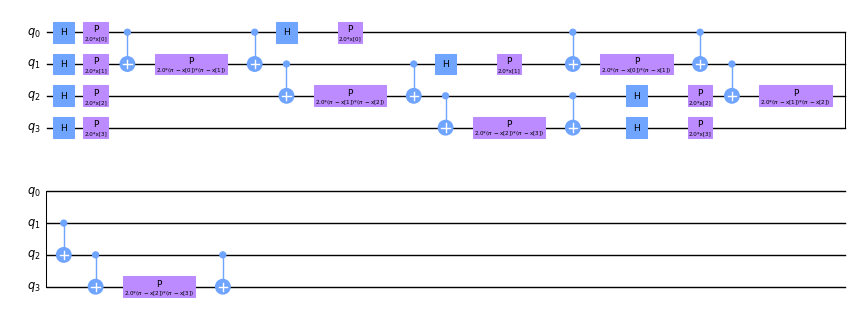

In [32]:
if feature_type=='ZZ':
    feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=feature_repeat, entanglement='linear')
else:
    feature_map = PauliFeatureMap(feature_dimension=feature_dim, reps=feature_repeat, entanglement='linear')
feature_map.decompose().draw('mpl', scale=0.7)

ansatz circuit (with trainable parameters)

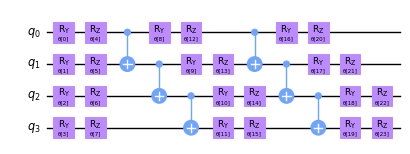

In [36]:
ansatz = TwoLocal(num_qubits=feature_dim, rotation_blocks=['ry', 'rz'],
                         entanglement_blocks='cx', entanglement='linear', reps=ansatz_repeat)
ansatz.bind_parameters(np.zeros(len(ansatz.parameters)))
ansatz.decompose().draw('mpl', scale=0.7)

combine feature map circuit and ansatz circuit to make a quantum neural network

In [34]:
qnn_circuit = feature_map.compose(ansatz)
num_classes = 2

qnn = CircuitQNN(circuit=qnn_circuit,
                 input_params=feature_map.parameters,  # if your embedding strategy is not a parametrized circuit 
                                                   # (e.g. amplitude encoding) you will have to do some extra work!
                 weight_params=ansatz.parameters,  # if you train your embedding as well, the trainable
                                                      # parameters of the embedding must be added
                 interpret=one_qubit_binary,
                 output_shape=num_classes,
                 gradient=None,
                 quantum_instance=qi_aer_qasm)

loss_recorder = []
spsa_opt = SPSA(maxiter=maxiter, callback=callback_wrapper(loss_recorder))
initial_point = np_rng.uniform(0,2*np.pi,size=len(ansatz.parameters))
vqc = NeuralNetworkClassifier(neural_network=qnn,
                              loss=CrossEntropyLoss(),
                              one_hot=True,
                              optimizer=spsa_opt,
                              initial_point=initial_point)

train and evalute the QNN model

21 - 26.679309407409033
42 - 25.888959711595046
63 - 25.279758646844797
84 - 24.965824170529242
105 - 24.52320927446881
126 - 24.340511950721925
147 - 24.13001428047971
168 - 23.948766843142533
189 - 24.131224988752223
210 - 23.53415893334317
231 - 23.557428280043556
252 - 22.857902840593287
273 - 22.223236990649987
294 - 21.820211901596487
accuracy on the train set (size=38): 0.9736842105263158
accuracy on the test set (size=10) 1.0


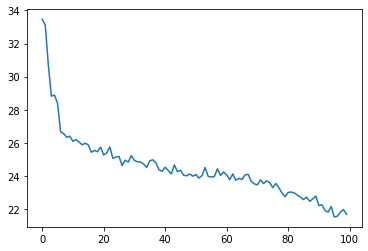

In [35]:
# train using train set
vqc.fit(x_train_normed, y_train_1h)

# evaluate on the train set and test set
train_accuracy = vqc.score(x_train_normed, y_train_1h)
test_accuracy = vqc.score(x_test_normed, y_test_1h)
print(f'accuracy on the train set (size={len(x_train)}): {train_accuracy}')
print(f'accuracy on the test set (size={len(x_test)}) {test_accuracy}')

# plot the loss curve
plt.plot(loss_recorder)

## QNN all in one

Bundle all above in one code block, and run it with different hyper-parameter. Please go through the section above to get the meaning of the below code.

In [24]:
def QNN_all_in_one(param):
    param = dict(param) #make a copy
    # set default value
    param.setdefault('feature_dim', 4)
    param.setdefault('resize_image_size', (2,2))
    param.setdefault('anti_aliasing', True)
    #anti_aliasing_sigma default to (s-1)/2 where s=44/2 is the downsamplign factor
    param.setdefault('anti_aliasing_sigma', None)
    # normalize the data into range [normalize_min,normalize_max]
    param.setdefault('normalize_min', 0)
    param.setdefault('normalize_max', 1)
    param.setdefault('feature_type', 'ZZ') #ZZ or Pauli
    # TODO amplitude encoding
    param.setdefault('feature_repeat', 2) #see ZZFeatureMap argument
    param.setdefault('ansatz_repeat', 2) #see TwoLocal argument
    param.setdefault('qasm_shots', 1024)
    param.setdefault('maxiter', 100)
    param.setdefault('seed', None)
    
    feature_dim = param['feature_dim']
    resize_image_size = param['resize_image_size']
    anti_aliasing = param['anti_aliasing']
    anti_aliasing_sigma = param['anti_aliasing_sigma']
    normalize_min = param['normalize_min']
    normalize_max = param['normalize_max']
    feature_type = param['feature_type']
    feature_repeat = param['feature_repeat']
    ansatz_repeat = param['ansatz_repeat']
    qasm_shots = param['qasm_shots']
    maxiter = param['maxiter']
    seed = param['seed']
    np_rng = np.random.default_rng(seed)

    # resize x_train to resize_image_size, and scale it to range [normalize_min,normalize_max]
    tmp0 = np.stack([skimage.transform.resize(x, resize_image_size,
                           anti_aliasing=anti_aliasing, anti_aliasing_sigma=anti_aliasing_sigma).reshape(-1) for x in x_train])
    scale_a = (normalize_max-normalize_min)/(tmp0.max()-tmp0.min())
    scale_b = normalize_min - tmp0.min()*scale_a
    x_train_normed = tmp0*scale_a + scale_b

    y_train_1h = get_one_hot_encoding(y_train)

    # resize x_test, and apply the same scale as x_train
    tmp0 = np.stack([skimage.transform.resize(x, resize_image_size,
                           anti_aliasing=anti_aliasing, anti_aliasing_sigma=anti_aliasing_sigma).reshape(-1) for x in x_test])
    x_test_normed = tmp0*scale_a + scale_b

    y_test_1h = get_one_hot_encoding(y_test)

    # print the shape, range information
    print('x_train_normed include {} images, each of shape ({}), range from {:.3f} to {:.3f}'.format(*x_train_normed.shape, x_train_normed.min(), x_train_normed.max()))
    print('x_test_normed include {} images, each of shape ({}), range from {:.3f} to {:.3f}'.format(*x_test_normed.shape, x_test_normed.min(), x_test_normed.max()))

    aer_qasm_sim = qiskit.providers.aer.QasmSimulator()
    qi_aer_qasm = qiskit.utils.QuantumInstance(aer_qasm_sim, shots=qasm_shots, seed_simulator=seed)

    if feature_type=='ZZ':
        feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=feature_repeat, entanglement='linear')
    else:
        feature_map = PauliFeatureMap(feature_dimension=feature_dim, reps=feature_repeat, entanglement='linear')

    ansatz = TwoLocal(num_qubits=feature_dim, rotation_blocks=['ry', 'rz'],
                     entanglement_blocks='cx', entanglement='linear', reps=ansatz_repeat)

    qnn_circuit = feature_map.compose(ansatz)
    num_classes = 2
    qnn = CircuitQNN(circuit=qnn_circuit, input_params=feature_map.parameters, weight_params=ansatz.parameters,
                interpret=one_qubit_binary, output_shape=num_classes, gradient=None, quantum_instance=qi_aer_qasm)

    loss_recorder = []
    spsa_opt = SPSA(maxiter=maxiter, callback=callback_wrapper(loss_recorder))
    initial_point = np_rng.uniform(0,2*np.pi,size=len(ansatz.parameters))
    vqc = NeuralNetworkClassifier(neural_network=qnn, loss=CrossEntropyLoss(),
                              one_hot=True, optimizer=spsa_opt, initial_point=initial_point)

    # train using train set
    vqc.fit(x_train_normed, y_train_1h)

    # evaluate on the train set and test set
    train_accuracy = vqc.score(x_train_normed, y_train_1h)
    test_accuracy = vqc.score(x_test_normed, y_test_1h)
    print(f'accuracy on the train set (size={len(x_train)}): {train_accuracy}')
    print(f'accuracy on the test set (size={len(x_test)}) {test_accuracy}')
    return param,train_accuracy, test_accuracy, loss_recorder


### compare `anti_aliasing=True` and `anti_aliasing=False`

`class_size=24` (total `48` samples)

| `anti_aliasing` | train-accuracy | test-accuracy |
| :-: | :-: | :-: |
| `True` | `0.894` | `0.8` |
| `False` | `0.605` | `0.4` |

conclusion: `anti_aliasing=True` is much better than `anti_aliasing=False`

x_train_normed include 38 images, each of shape (4), range from 0.000 to 1.000
x_test_normed include 10 images, each of shape (4), range from 0.224 to 0.962
21 - 35.93101650312021
42 - 27.672731961215792
63 - 27.757870288589256
84 - 27.085656208072823
105 - 26.809800656782766
126 - 26.179303421349836
147 - 25.07543678710252
168 - 24.66124313460952
189 - 24.437921628123547
210 - 24.34999540029533
231 - 24.569608507249665
252 - 23.834100574685426
273 - 24.108922875837678
294 - 23.806716868721523
accuracy on the train set (size=38): 0.8947368421052632
accuracy on the test set (size=10) 0.8


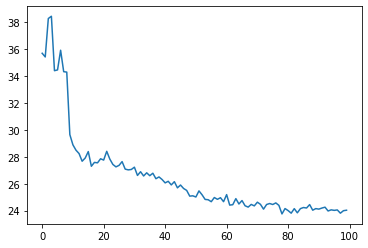

In [25]:
param = {'anti_aliasing':True, 'seed':None}
param, train_accuracy, test_accuracy, loss_recorder = QNN_all_in_one(param)
save_result(param=param, train_accuracy=train_accuracy, test_accuracy=test_accuracy, loss_recorder=loss_recorder)
plt.plot(loss_recorder)

x_train_normed include 38 images, each of shape (4), range from 0.000 to 1.000
x_test_normed include 10 images, each of shape (4), range from 0.001 to 1.000
21 - 36.97136168072581
42 - 40.132332969676916
63 - 36.46819220520971
84 - 35.64665409342175
105 - 35.80418674717486
126 - 34.59375882793228
147 - 34.95848731204367
168 - 34.972315222330586
189 - 34.6013246379594
210 - 35.05461130809996
231 - 35.45631988792084
252 - 34.48888725811072
273 - 34.672502753711555
294 - 34.97914314771239
accuracy on the train set (size=38): 0.6052631578947368
accuracy on the test set (size=10) 0.4


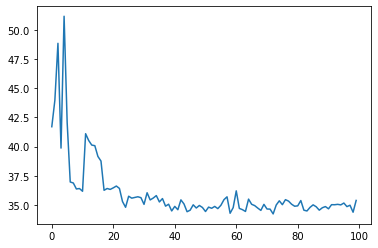

In [26]:
param = {'anti_aliasing':False, 'seed':None}
param, train_accuracy, test_accuracy, loss_recorder = QNN_all_in_one(param)
save_result(param=param, train_accuracy=train_accuracy, test_accuracy=test_accuracy, loss_recorder=loss_recorder)
plt.plot(loss_recorder)

### compare `resize_image_size`

for different `resize_image_size`, we have to use equal number of qubits `#qubit=height*width`

`class_size=24` (total `48` samples)

| `resize_image_size` | train-accuracy | test-accuracy |
| :-: | :-: | :-: |
| `(1,2)` | `0.842` | `0.7` |
| `(2,1)` | `0.71` | `0.7` (diverge) |
| `(2,2)` | `0.894` | `0.8` |
| `(3,3)` | `0.947` | `0.8` |

conclusion: model with more qubits might be better

x_train_normed include 38 images, each of shape (2), range from 0.000 to 1.000
x_test_normed include 10 images, each of shape (2), range from 0.314 to 0.988
21 - 29.535597305665405
42 - 25.23635762308271
63 - 21.364677289158383
84 - 20.997069925669024
105 - 20.107128833158576
126 - 19.82172568267625
147 - 19.50782364552782
168 - 19.499445376258233
189 - 19.04328181550771
210 - 19.463797102722125
231 - 18.99235801899114
252 - 19.297598931418303
273 - 18.432056444372442
294 - 18.47836777176418
accuracy on the train set (size=38): 0.8421052631578947
accuracy on the test set (size=10) 0.7
x_train_normed include 38 images, each of shape (2), range from 0.000 to 1.000
x_test_normed include 10 images, each of shape (2), range from 0.361 to 0.987


/home/zhangc/miniconda3/envs/cuda113/lib/python3.9/site-packages/qiskit_machine_learning/utils/loss_functions/loss_functions.py:158: RuntimeWarning: divide by zero encountered in log2
  val = -np.einsum("ij,ij->i", target, np.log2(predict)).reshape(-1, 1)
/home/zhangc/miniconda3/envs/cuda113/lib/python3.9/site-packages/qiskit/algorithms/optimizers/spsa.py:348: UserWarning: Calibration failed, using 0.6283185307179586 for `a`
  warnings.warn(f"Calibration failed, using {target_magnitude} for `a`")


21 - 47.16335419474818
42 - 33.13265609892715
63 - 44.09867151718969
84 - 34.44813463282164
105 - 33.96717125463448
126 - 31.37468015388672
147 - 26.848286610636677
168 - 32.306136404691166
189 - 35.77018638884079
210 - 39.226585619756285
231 - 46.58830597379721
252 - 29.151314177092917
273 - 26.81260322357668
294 - 46.3913524185238
accuracy on the train set (size=38): 0.7105263157894737
accuracy on the test set (size=10) 0.7
x_train_normed include 38 images, each of shape (4), range from 0.000 to 1.000
x_test_normed include 10 images, each of shape (4), range from 0.224 to 0.962
21 - 39.90861414257271
42 - 26.826043048495986
63 - 26.2391757658665
84 - 25.90348796456299
105 - 25.65609101674254
126 - 25.207625763188396
147 - 25.17743209125653
168 - 24.35089217733061
189 - 23.648935098468936
210 - 23.750075756037898
231 - 23.762742835392203
252 - 23.918091674467448
273 - 23.654004466815433
294 - 23.640897113889523
accuracy on the train set (size=38): 0.8947368421052632
accuracy on the te

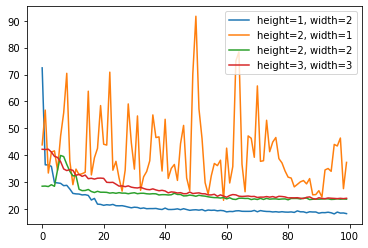

In [30]:
param = {'anti_aliasing':True, 'feature_dim':2, 'resize_image_size':(1,2)}
param, train_accuracy, test_accuracy, loss_1_2 = QNN_all_in_one(param)
save_result(param=param, train_accuracy=train_accuracy, test_accuracy=test_accuracy, loss_recorder=loss_1_2)

param = {'anti_aliasing':True, 'feature_dim':2, 'resize_image_size':(2,1)}
param, train_accuracy, test_accuracy, loss_2_1 = QNN_all_in_one(param)
save_result(param=param, train_accuracy=train_accuracy, test_accuracy=test_accuracy, loss_recorder=loss_2_1)
# this one diverge

param = {'anti_aliasing':True, 'feature_dim':4, 'resize_image_size':(2,2)}
param, train_accuracy, test_accuracy, loss_2_2 = QNN_all_in_one(param)
save_result(param=param, train_accuracy=train_accuracy, test_accuracy=test_accuracy, loss_recorder=loss_2_2)

param = {'anti_aliasing':True, 'feature_dim':9, 'resize_image_size':(3,3)}
param, train_accuracy, test_accuracy, loss_3_3 = QNN_all_in_one(param)
save_result(param=param, train_accuracy=train_accuracy, test_accuracy=test_accuracy, loss_recorder=loss_3_3)

fig,ax = plt.subplots()
ax.plot(loss_1_2, label='height=1, width=2')
ax.plot(loss_2_1, label='height=2, width=1')
ax.plot(loss_2_2, label='height=2, width=2')
ax.plot(loss_3_3, label='height=3, width=3')
ax.legend()